In [246]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

rozpietosc = math.pi/2
dx = 2.0
n = math.ceil(180/dx)+1
liczbaDetektorow = 160

def podajKrokAlfa(krok):
    global dAlfa 
    dAlfa = krok*math.pi/180
def podajIloscDetektorow(ile):
    global liczbaDetektorow 
    liczbaDetektorow = ile
def podajRozpietosc(stopnie):
    global rozpietosc 
    rozpietosc = stopnie*math.pi/180


interact(podajKrokAlfa,krok=widgets.FloatSlider(description='Krok alfa:',min=0.5,max=5.0,step=0.5,value=2.0))
interact(podajIloscDetektorow,ile=widgets.IntSlider(description='Liczba detektorów:',min=1,max=250,step=1,value=50))
interact(podajRozpietosc,stopnie=widgets.IntSlider(description='Rozpiętość:',min=0,max=180,step=10,value=90))
 


interactive(children=(FloatSlider(value=2.0, description='Krok alfa:', max=5.0, min=0.5, step=0.5), Output()),…

interactive(children=(IntSlider(value=50, description='Liczba detektorów:', max=250, min=1), Output()), _dom_c…

interactive(children=(IntSlider(value=90, description='Rozpiętość:', max=180, step=10), Output()), _dom_classe…

<function __main__.podajRozpietosc(stopnie)>

0.03490658503988659


C:\Users\Szymon\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


(250, 361)
0.5 120.0 250


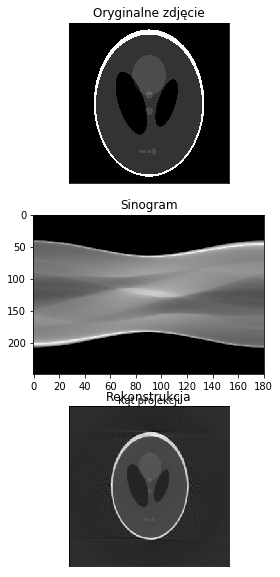

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [250]:
from scipy import misc
from bresenham import bresenham
from scipy.interpolate import interp1d
from scipy.fftpack import fft, ifft, fftfreq
import math 
import numpy as np
import matplotlib.pyplot as plt

dx=180*dAlfa/math.pi
alfa = math.pi/2
n = math.ceil(180/dx)+1
detektory = [[0,0] for i in range(liczbaDetektorow)]
emitery = [[0,0] for i in range(liczbaDetektorow)]
zdjecie = misc.imread('Shepp_logan.jpg', flatten=True).astype('float64')
wysokosc = len(zdjecie)
szerokosc = len(zdjecie[0])
r = math.floor(math.sqrt(wysokosc**2 + szerokosc**2)/2) 

obraz = [[0 for i in range(r*2)] for j in range(r*2)]
w,s = zdjecie.shape
yoff = round((r*2-w)/2)
xoff = round((r*2-s)/2)
obraz = np.array(obraz.copy())
obraz[yoff:yoff+w,xoff:xoff+s] = zdjecie
kat = []
sinogram = []
for j in range(n):
    kat.append(j*dAlfa)
    linia = [0 for i in range(liczbaDetektorow)]
    for i in range(liczbaDetektorow):
        x = r*math.cos(alfa + math.pi - (1/2)*rozpietosc + i*(rozpietosc/(liczbaDetektorow-1))+(j*dAlfa))
        y = r*math.sin(alfa + math.pi - (1/2)*rozpietosc + i*(rozpietosc/(liczbaDetektorow-1))+(j*dAlfa))
        detektory[i] = [round(x),round(y)]
        xe = r*math.cos(alfa + (1/2)*rozpietosc - i*(rozpietosc/(liczbaDetektorow-1))+(j*dAlfa))
        ye = r*math.sin(alfa + (1/2)*rozpietosc - i*(rozpietosc/(liczbaDetektorow-1))+(j*dAlfa))
        emitery[i] = [round(xe),round(ye)]
        punkty_linii = list(bresenham(emitery[i][0],emitery[i][1],detektory[i][0],detektory[i][1]))
        k = 0
        for xp,yp in punkty_linii:
            linia[i] += obraz[xp+r-1][yp+r-1]
            k += 1
            
        linia[i] /= k

    sinogram.append(linia)

sinogram = np.rot90(sinogram,1, axes=(0,1))

theta = np.linspace(0.0,180.0, sinogram.shape[1], endpoint=False)
print(sinogram.shape)
theta = theta*np.pi/180.0

#rekonstrukcja Filtrowana Projekcja Wsteczna

wSin = sinogram.shape[0]

projection_size_padded = \
        max(64, int(2 ** np.ceil(np.log2(2 * wSin))))
pad_width = ((0, projection_size_padded - wSin), (0, 0))
img = np.pad(sinogram, pad_width, mode='constant', constant_values=0)

f = fftfreq(projection_size_padded).reshape(-1,1)
omega = 2*np.pi*f
filtrFouriera = 2*np.abs(f)
projekcja = fft(img, axis=0) * filtrFouriera
zfiltrowanyObraz = np.real(ifft(projekcja, axis=0))[:wSin, :]


rekonstrukcja = np.zeros((wSin, wSin))
srodek = wSin // 2

[X,Y] = np.mgrid[0:wSin,0:wSin]
xpr = X - int(wSin)//2
ypr = Y - int(wSin)//2

for i in range(len(theta)):
    t = ypr*np.cos(theta[i]) - xpr* np.sin(theta[i])
    s = np.arange(zfiltrowanyObraz.shape[0]) - srodek
    wstecznaProjekcja = np.interp(t,s,zfiltrowanyObraz[:,i], left=0, right=0)
    rekonstrukcja += wstecznaProjekcja
rekonstrukcja = rekonstrukcja * np.pi/(2*len(theta))
rekonstrukcja = np.rot90(rekonstrukcja,1, axes=(0,1))


plt.figure(figsize=(10,10))
sub1 = plt.subplot(311)
sub2 = plt.subplot(312)
sub3 = plt.subplot(313)

plt.figure(figsize=(5,5))
sub1.set_title("Oryginalne zdjęcie")
sub1.set_xticks([],[])
sub1.set_yticks([],[])
sub1.imshow(zdjecie, cmap='gray')

xlabels=[i*20 for i in range(10)]
sub2.set_xticks(np.arange(0, 181/dx, 20/dx))
sub2.set_xticklabels(xlabels)
sub2.set_xlabel("Kąt projekcji")
sub2.set_title("Sinogram")
sub2.imshow(sinogram, cmap='gray')

plt.figure(figsize=(5,5))
sub3.set_title("Rekonstrukcja")
sub3.set_xticks([],[])
sub3.set_yticks([],[])
sub3.imshow(rekonstrukcja, cmap='gray')
print(dAlfa/math.pi*180, rozpietosc/math.pi*180, liczbaDetektorow)